**ConcertAI Techtest** <br>
**Author**: Vinay Barnabas


In [346]:
# importing necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# muting FutureWarnings. These are warnings about features that will be removed in a future version
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

*Plotting conventions for the notebook*

In [343]:
# define plot style
def set_plot_style():
    '''
    function to set figure parameters
    Inputs: None
    Return: None
    '''

    # define style: plots will not have gridlines. X- and y- ticks would be present
    sns.set_style('ticks')

    # parameter to control scaling of plot elements.
    sns.set_context('notebook')

    # fix figure parameters
    plt.rcParams['figure.figsize'] = (10,6)
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['lines.linewidth'] = 2
    
    # fix color palette
    sns.set_palette('muted')

def frame_off(ax):
    '''
    function to remove outframe in plots
    Inputs: ax = plot axes
    Return: Nothing
    '''
    for _, spines in ax.spines.items():
        spines.set_visible(False)


# fix figure paraeters by calling the function
set_plot_style()

## Data Exploration and Cleaning

In [332]:
# Establish connection to sqlite3 database and define a cursor
con = sqlite3.connect("techTest.db")
cur = con.cursor()

In [316]:
# query to extract table info from sqlite_master
cur.execute('''
                SELECT name
                FROM sqlite_master
                WHERE type = "table";
            ''')

# for each table display PRAGMA table information
for item in cur.fetchall():
    print(f"Column Name: {item[0]}")
    print(50*"-")
    print("with columns")
    cur.execute(f"PRAGMA table_info({item[0]})")
    column_info = cur.fetchall()
    for col in column_info:
        print(col)
    print("\n")    

Column Name: patient
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'dob', 'TIMESTAMP', 0, None, 0)
(2, 'dod', 'TIMESTAMP', 0, None, 0)
(3, 'gender', 'TEXT', 0, None, 0)


Column Name: diagnosis
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'diagnosis_date', 'TIMESTAMP', 0, None, 0)
(2, 'diagnosis_code', 'TEXT', 0, None, 0)
(3, 'diagnosis_code_type', 'TEXT', 0, None, 0)


Column Name: biomarker
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'test_date', 'TIMESTAMP', 0, None, 0)
(2, 'biomarker_name', 'TEXT', 0, None, 0)
(3, 'biomarker_test_type', 'TEXT', 0, None, 0)
(4, 'test_result', 'TEXT', 0, None, 0)




*Do patients have multiple date of births?*

In [317]:
cur.execute('''
            SELECT p.patient_id,
            CASE
            WHEN MIN(p.dob) = MAX(p.dob) THEN 1
            ELSE 0
            END Is_dob_same

            FROM Patient as p
            GROUP BY p.patient_id
  
            
            ''')
count_is_same = 0
count_rows = 0
for item in cur.fetchall():
    count_rows+=1
    count_is_same+=item[1]

assert count_rows == count_is_same, "A patient has multiple dobs"


*Is date of birth later than date of death?*

In [318]:
cur.execute('''
            SELECT COUNT(*)
            FROM Patient
            WHERE dob > dod
            ''')
count_is_same = 0
count_rows = 0
assert cur.fetchall()[0][0] == 0, "Date of Birth is later than Date of death"

*Is date of death later than 2024?*

In [319]:
cur.execute('''
                SELECT COUNT(*)
                FROM patient
                WHERE STRFTIME("%Y",dod) > STRFTIME("%Y","now");
             
            ''')

num_dodbiggernow = cur.fetchone()[0]
print(f"Number of records in Patients table where date of death is later than current date: {num_dodbiggernow}")

Number of records in Patients table where date of death is later than current date: 174


*Is date of death earlier than earliest date of diagnosis?*

**OBSERVATION**: <br>
- There are multiple instances of patients. Hence multiples dates of diagnosis
- Date of births are the same for the grouped patients ids

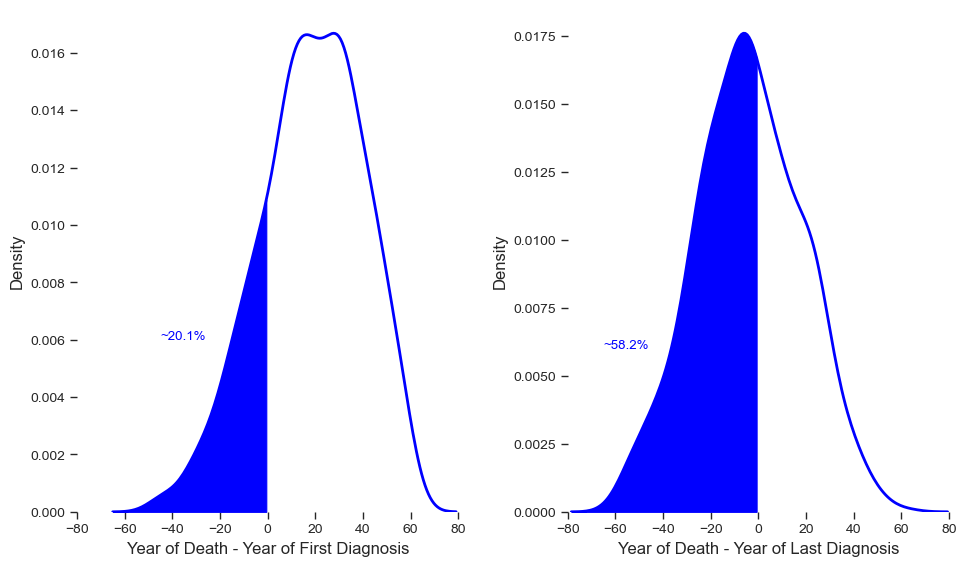

In [320]:
query = '''
            SELECT p.patient_id, STRFTIME("%Y", p.dod) - STRFTIME("%Y",MIN(d.diagnosis_date)) as dod_firstdiagnosis, STRFTIME("%Y", p.dod) - STRFTIME("%Y",MAX(d.diagnosis_date)) as dod_lastdiagnosis
            FROM Patient as p LEFT JOIN Diagnosis as d ON p.patient_id = d.patient_id 
            
            GROUP BY p.patient_id
            HAVING (d.diagnosis_code LIKE "C50%")
        '''
df_dod_diagnosis = pd.read_sql_query(query, con)
#count_is_same = 0
#query_records = cur.fetchall()
#print(f"Number of records with date of death is sooner than date of first diagnosis: {len(query_records)}")
fig, ax = plt.subplots(1,2)
kde_dod_firstdiagnosis = sns.kdeplot(df_dod_diagnosis, 
                                     x = "dod_firstdiagnosis",
                                     color = "b", 
                                     ax = ax[0])

kde_dod_lastdiagnosis = sns.kdeplot(df_dod_diagnosis, 
                                    x = "dod_lastdiagnosis",
                                    color = "b", 
                                    ax = ax[1])

l1 = kde_dod_firstdiagnosis.lines[0]
l2 = kde_dod_lastdiagnosis.lines[0]
x1, y1 = l1.get_xydata()[:,0], l1.get_xydata()[:,1]
x2, y2 = l2.get_xydata()[:,0], l2.get_xydata()[:,1]

kde_dod_firstdiagnosis.fill_between(x1, y1, 
                                    where = x1<=0, 
                                    color = "b")
kde_dod_lastdiagnosis.fill_between(x2, y2, 
                                   where = x2<=0, 
                                   color = "b")

ax[0].set_xlabel("Year of Death - Year of First Diagnosis")
ax[0].text(-45, 0.006, f"~{100*(df_dod_diagnosis['dod_firstdiagnosis'] < 0).mean():0.1f}%", color = "b")
ax[1].set_xlabel("Year of Death - Year of Last Diagnosis")
ax[1].text(-65, 0.006, f"~{100*(df_dod_diagnosis['dod_lastdiagnosis'] < 0).mean():0.1f}%", color = "b")
ax[0].set_xlim([-80, 80])
ax[1].set_xlim([-80, 80])
frame_off(ax[0])
frame_off(ax[1])
fig.tight_layout(pad = 2)

In [333]:
con.close()

**Method 1**: <br>
- Remove patients where date of death < Year of first diagnosis <br>

_Follow-up time_ = MIN(diagnosis_date) - Max(diagnosis_date, biomarker_test_date) <br>

_Censored_ = Date of death > Max(diagnosis_date, biomarker_test)

_Event_ = Date of death < Max(diagnosis_date, biomarker_test)

**Method 2**: <br>
- Remove patients where date of death < Year of first diagnosis <br>

_Follow-up time_ = MIN(diagnosis_date) - Max(diagnosis_date, biomarker_test_date, date of death) <br>

_Censored_ = Date of death > Max(diagnosis_date, biomarker_test)






## Data maturity 
    - Calculate the summary statistics and plot the distribution of follow up time for BC patients.
    - Calculate the summary statistics and plot the distribution of age at initial diagnosis for BC patients

In [334]:
con = sqlite3.connect("techTest.db")
cur = con.cursor()

query_survival= '''
                SELECT p.patient_id, date(p.dod) as dod, STRFTIME("%Y",p.dod) - STRFTIME("%Y",p.dob) as age, p.gender, STRFTIME("%Y", MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis, date(MIN(d.diagnosis_date)) as first_diagnosis_date, date(MAX(d.diagnosis_date)) as last_diagnosis_date, date(MAX(b.test_date)) as last_test_date
                FROM patient as p LEFT JOIN diagnosis as d ON p.patient_id = d.patient_id LEFT JOIN biomarker as b ON p.patient_id = b.patient_id
                GROUP BY p.patient_id        
                HAVING d.diagnosis_code LIKE "C50%"
                '''

df = pd.read_sql_query(query_survival, con)
print(f"Size of the table: {df.shape[0]} x {df.shape[1]}")
df.head()

Size of the table: 795 x 8


,patient_id,dod,age,gender,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,65,male,50,1993-04-07,2019-05-20,2004-12-19
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,73,NULL,21,1986-06-02,2021-10-13,2023-12-29
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,76,female,30,1996-10-05,2020-06-13,2018-03-10
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,56,NULL,26,1977-01-16,1981-10-28,1995-12-08
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,74,male,26,1956-06-03,2005-01-07,2021-07-29


In [335]:
time_format_cols = ["first_diagnosis_date", "last_diagnosis_date", "last_test_date"]
for col in time_format_cols:
    df[col] = pd.to_datetime(df[col])

def cal_last_encounter(row):
    if row["last_diagnosis_date"] > row["last_test_date"]:
        return row["last_diagnosis_date"]
    else:
        return row["last_test_date"]


df["last_encounter_date"] = df.apply(cal_last_encounter, axis = 1)
df.head()

,patient_id,dod,age,gender,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,65,male,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,73,NULL,21,1986-06-02,2021-10-13,2023-12-29,2023-12-29
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,76,female,30,1996-10-05,2020-06-13,2018-03-10,2020-06-13
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,56,NULL,26,1977-01-16,1981-10-28,1995-12-08,1995-12-08
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,74,male,26,1956-06-03,2005-01-07,2021-07-29,2021-07-29


In [336]:
df["follow_up_time"] = ((df["last_encounter_date"] - df["first_diagnosis_date"]).dt.days/365.25).round(1)
#patient is event if dod < last_encounter_date while censored if dod > last_encounter_date
df["status"] = (df["dod"] < df["last_encounter_date"]).astype(int)
df.head()

,patient_id,dod,age,gender,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date,follow_up_time,status
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,65,male,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20,26.1,1
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,73,NULL,21,1986-06-02,2021-10-13,2023-12-29,2023-12-29,37.6,0
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,76,female,30,1996-10-05,2020-06-13,2018-03-10,2020-06-13,23.7,0
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,56,NULL,26,1977-01-16,1981-10-28,1995-12-08,1995-12-08,18.9,0
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,74,male,26,1956-06-03,2005-01-07,2021-07-29,2021-07-29,65.2,1


In [337]:
print(f"Number of patients with DOD < first diagnosis: {(df['dod'] < df['first_diagnosis_date']).sum()}")
print(f"Patients allegedly censored: {(df['status']).mean()}")

Number of patients with DOD < first diagnosis: 154
Patients allegedly censored: 0.6955974842767295


In [338]:
df.isna().sum()

patient_id              0
dod                     0
age                     0
gender                  0
age_at_diagnosis        0
first_diagnosis_date    0
last_diagnosis_date     0
last_test_date          0
last_encounter_date     0
follow_up_time          0
status                  0
dtype: int64

In [339]:
df[["age_at_diagnosis", "follow_up_time"]].describe()

,age_at_diagnosis,follow_up_time
count,795.000000,795.000000
mean,35.250314,29.546667
std,14.637569,16.296737
min,19.000000,0.000000
25%,24.000000,19.300000
50%,31.000000,29.800000
75%,42.000000,40.500000
max,89.000000,73.700000


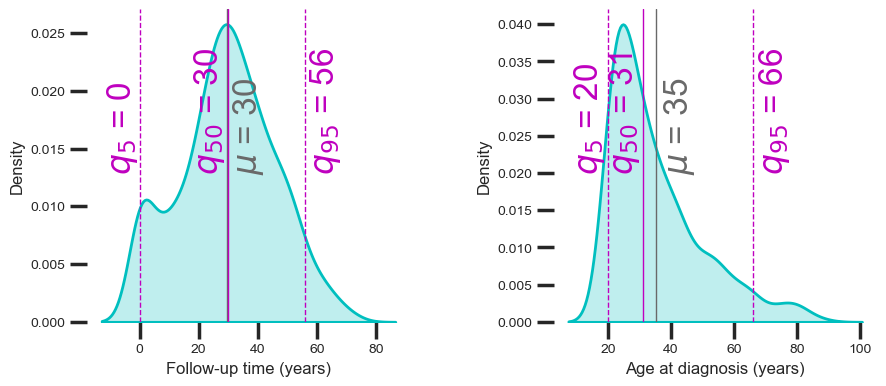

In [340]:
fig, axes = plt.subplots(1,2, figsize = (10,5))

p1 = sns.kdeplot(
    df,
    x = "follow_up_time",
    fill = True,
    color = "c",
    ax = axes[0]

)

p2 = sns.kdeplot(
    df,
    x = "age_at_diagnosis",
    fill = True,
    color = "c",
    ax = axes[1]
)
axes[0].set_xlabel("Follow-up time (years)")
axes[1].set_xlabel("Age at diagnosis (years)")

def summary_stats(x, ax):
    '''
        function to plot mean, median, and 5% and  95% quantile of axes ax
        in: ax = axes
            x = column name
        
        return: nothing. plots vertical lines 
    '''
    # calculate summary statistics: mean, median, and interquantile range
    mu_x, med_x = df[x].mean(), df[x].median()
    alpha_x, oneminusalpha_x = df[x].quantile(q = [0.05, 0.95])
    
    # calculate y-axis text label position
    y_limit_plot = ax.get_ylim()
    y_pos = np.mean(y_limit_plot)

    # plot mean and its text label
    ax.axvline(mu_x, lw = 1, color = "dimgray")
    ax.text(mu_x*1.05, y_pos, f"$\mu$ = {np.round(mu_x,0):0.0f}", horizontalalignment = "left", rotation = "vertical", color = "dimgray")
    
    # plot median and its label
    ax.axvline(med_x, lw = 1, color = "m")
    ax.text(med_x*0.99, y_pos, f"$q_{{50}}$ = {np.round(med_x,0):0.0f}", horizontalalignment = "right", rotation = "vertical", color = "m")
    
    # plot 5% quantile and its text label
    ax.axvline(alpha_x, lw = 1, ls = '--', color = "m")
    ax.text(alpha_x*0.99, y_pos, f"$q_{{5}}$ = {np.round(alpha_x,0):0.0f}", horizontalalignment = "right", rotation = "vertical", color = "m")
    
    # plot 95% quantile and its text label
    ax.axvline(oneminusalpha_x, lw = 1, ls = "--", color = "m")
    ax.text(oneminusalpha_x*1.02, y_pos, f"$q_{{95}}$ = {np.round(oneminusalpha_x,0):0.0f}", horizontalalignment = "left", rotation = "vertical", color = "m")

summary_stats("follow_up_time", axes[0])
summary_stats("age_at_diagnosis", axes[1])
fig.tight_layout(pad = 2)

frame_off(axes[0])
frame_off(axes[1])
#axes[0].box(False)
plt.show()

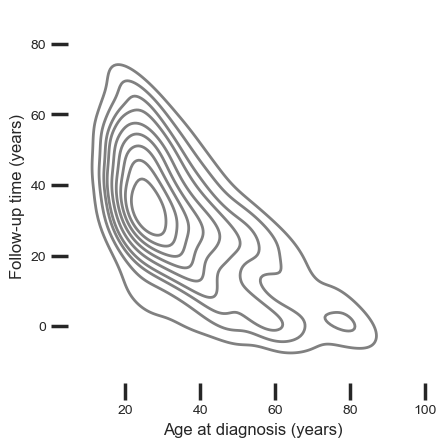

In [341]:
sns.displot(df, x = "age_at_diagnosis", y = "follow_up_time", kind = "kde", color = "gray")
plt.xlabel("Age at diagnosis (years)")
plt.ylabel("Follow-up time (years)")
plt.box(False)
plt.show()

In [342]:
con.close()

## HER2 status
    - Calculate the intent to test rate for HER2. 
    - Calculate the tested rate for HER2.
    - Calculate the negativity rate for HER2.

In [278]:
con = sqlite3.connect("techTest.db")
cur = con.cursor()

### Intent to Test Rate

In [279]:
cur.execute('''
                SELECT AVG(CASE WHEN b.biomarker_name = "HER2" 
                                THEN 1 
                                ELSE 0 
                            END)
                FROM patient as p LEFT JOIN biomarker as b on p.patient_id = b.patient_id
                WHERE p.patient_id IN (
                                        SELECT patient_id
                                        FROM diagnosis
                                        WHERE diagnosis_code LIKE "C50%"
                                        )

            ''')
intent_to_test_rate = cur.fetchone()[0]
print(f"Intent to test rate is {intent_to_test_rate :0.2f}")

Intent to test rate is 0.50


### Tested Rate

In [280]:
cur.execute('''
                SELECT AVG(CASE WHEN (COALESCE(b.biomarker_name,0) = "HER2") AND (COALESCE(b.biomarker_test_type,0) in ("PCR", "IHC")) 
                                THEN 1 
                                ELSE 0 
                            END)
                FROM patient as p LEFT JOIN biomarker as b on p.patient_id = b.patient_id
                WHERE p.patient_id IN (
                                        SELECT patient_id
                                        FROM diagnosis
                                        WHERE diagnosis_code LIKE "C50%"
                                        )

            ''')
test_rate = cur.fetchone()[0]
print(f"Test rate = {test_rate :0.2f}")

Test rate = 0.31


### Negativity Rate

Here, I am assuming that unknown is 0

In [281]:
cur.execute('''
                SELECT AVG(CASE WHEN (b.biomarker_name = "HER2") AND (b.test_result = "Negative") 
                                THEN 1 
                                ELSE 0 
                            END)
                FROM patient as p LEFT JOIN biomarker as b on p.patient_id = b.patient_id
                WHERE p.patient_id IN (
                                        SELECT patient_id
                                        FROM diagnosis
                                        WHERE diagnosis_code LIKE "C50%"
                                        )

            ''')
negative_rate = cur.fetchone()[0]
print(f"Negativity rate = {negative_rate :0.2f}")

Negativity rate = 0.14


In [282]:
con.close()

## Survival Analysis

In [283]:
assert (df["follow_up_time"] < 0).sum() == 0

df.isna().sum()

patient_id              0
dod                     0
age                     0
gender                  0
age_at_diagnosis        0
first_diagnosis_date    0
last_diagnosis_date     0
last_test_date          0
last_encounter_date     0
follow_up_time          0
status                  0
dtype: int64

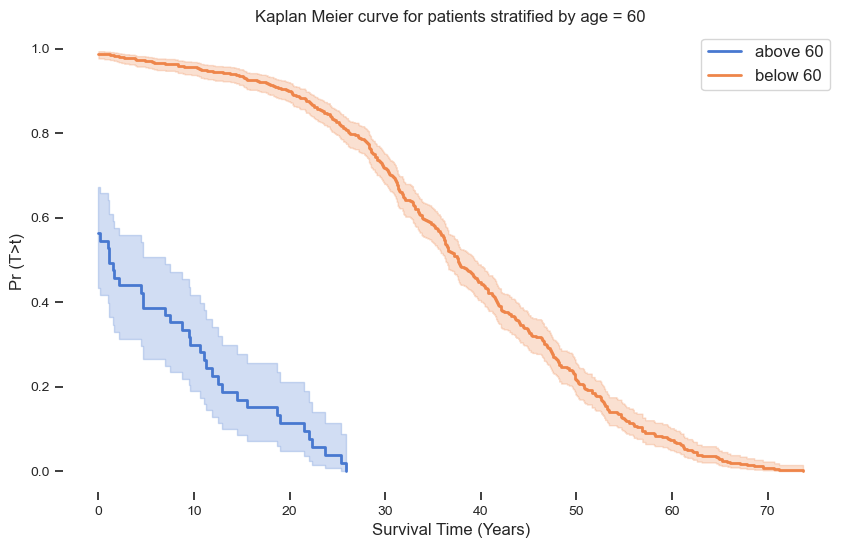

In [293]:
stratify_age = 60
mask = df["age_at_diagnosis"] > stratify_age
fig, axes = plt.subplots()

km = KaplanMeierFitter()
km_lowerage = km.fit(df.loc[mask,"follow_up_time"], df.loc[mask,"status"])
km_lowerage.plot(label = f"above {stratify_age}")
km_upperage = km.fit(df.loc[~mask,"follow_up_time"], df.loc[~mask,"status"])
km_upperage.plot(label = f"below {stratify_age}", xlabel = "Survival Time (Years)", ylabel = "Pr (T>t)")
plt.legend(fontsize = 12)
plt.box(False)
plt.title(f"Kaplan Meier curve for patients stratified by age = {stratify_age}")
plt.show()

In [287]:
stats_results = logrank_test(df.loc[mask,"follow_up_time"], df.loc[~mask,"follow_up_time"], 
                             df.loc[mask,"status"], df.loc[~mask,"status"])

stats_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         580.79 <0.005    423.87

## Miscellaneous

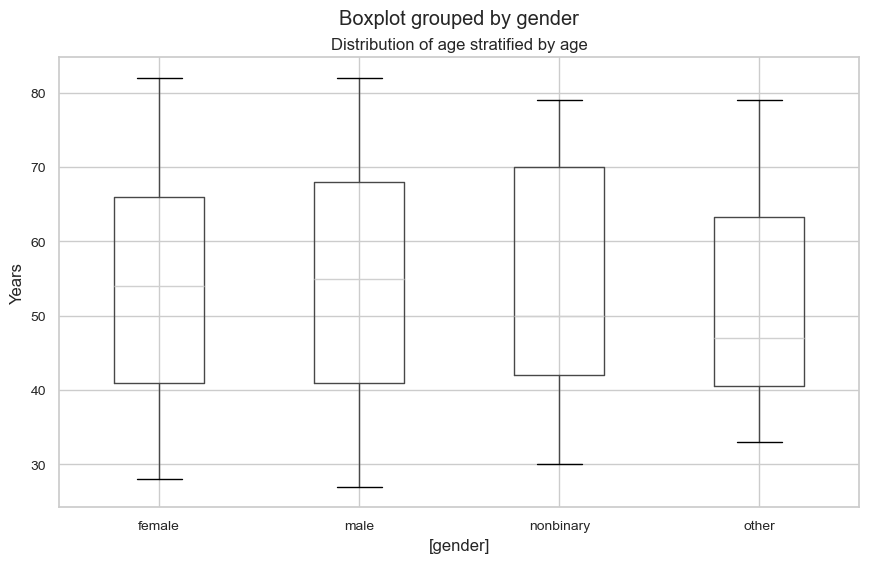

In [ ]:
query_age = '''
                SELECT STRFTIME("%Y",dod) - STRFTIME("%Y",dob) as age, gender
                FROM patient
                WHERE gender != "NULL"
                '''
df_age = pd.read_sql_query(query_age, con)
df_age.boxplot(by = "gender")
plt.title("Distribution of age stratified by age")
plt.ylabel("Years")
plt.show()

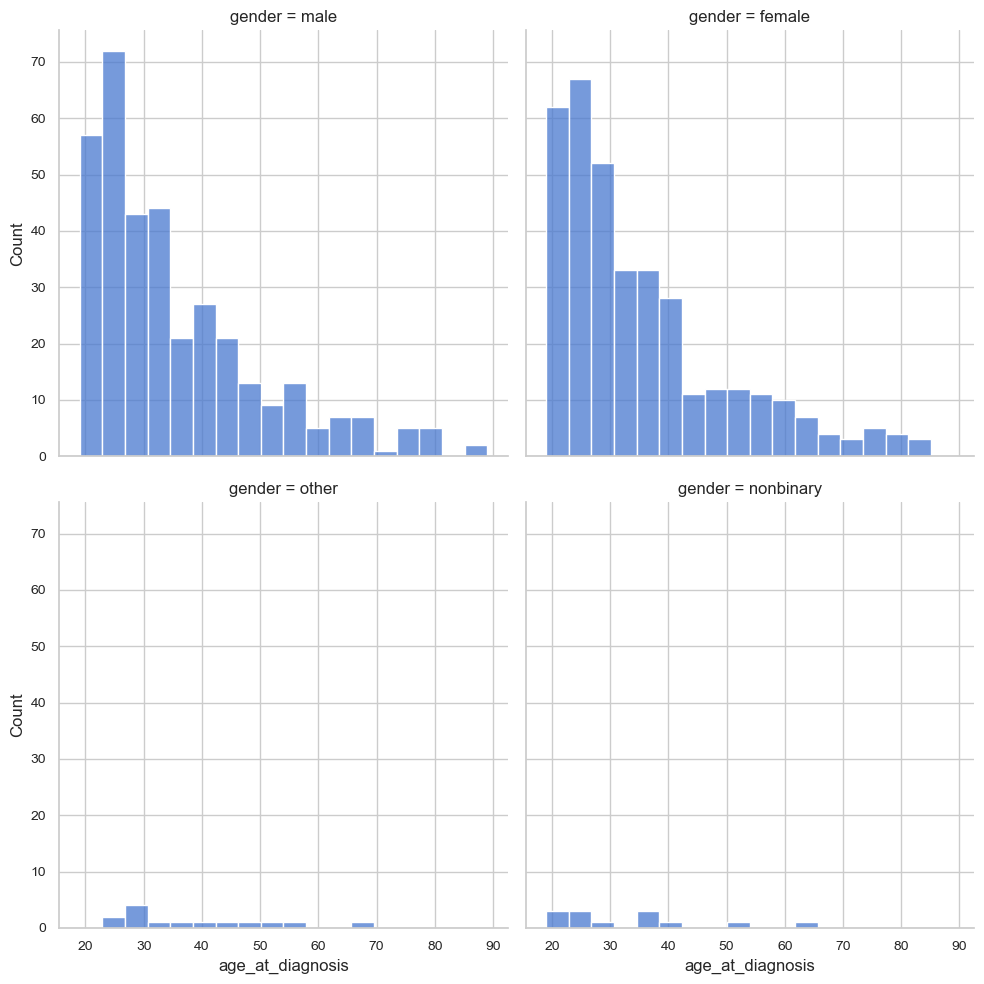

In [ ]:
sns.displot(df, x = "age_at_diagnosis", col = "gender", col_wrap = 2)
plt.show()

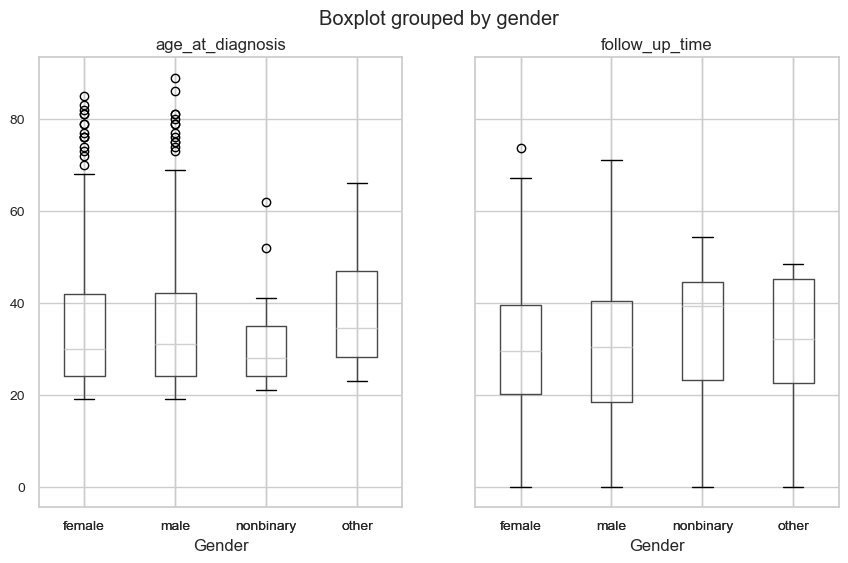

In [ ]:
df_removenull = df[df["gender"]!="NULL"]
df_removenull[["follow_up_time", "age_at_diagnosis", "gender"]].boxplot(by = "gender", xlabel = "Gender")
fig.tight_layout(pad = 2)
plt.show()